### Imports

In [ ]:
import os
import math
import glob
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import neptune.new as neptune
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import pixel_shuffle
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import create_feature_extractor
#from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as PSNR

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

seed = 2020
torch.manual_seed(seed)
device = (torch.device('cuda') if torch.has_cuda else torch.device('cpu'))
print(device)

In [2]:
data_dir = r'C:\Users\Ziv Yogev\Desktop\Programming\WPDL\Assignment3\VOC2007'
# data_dir = r'/workspace/VOCdevkit/VOC2007'
images = glob.glob(data_dir + "/JPEGImages/*")
list_images = []
print(f'Total number of Images: {len(images)}')
for idx, i in enumerate(images):
    list_images.append(i)

Total number of Images: 5011


### Step 1 - Dataset & Dataloader
By using self-supervision, create a dataset and a data-loader for the training of super-resolution network

In [3]:
class BlurryDataset(Dataset):    
    def __init__(self,list_images, number1, number2, number3):
        self.list_of_path_img = list_images
        self.transform1 = transforms.Compose([transforms.Resize((number1,number1))])
        self.transform2 = transforms.Compose([transforms.Resize((number2,number2))])
        self.transform3 = transforms.Compose([transforms.Resize((number3,number3))])

    def __len__(self):
        return len(self.list_of_path_img)
    
    def __getitem__(self,idx):
        image = read_image(self.list_of_path_img[idx])

        x = self.transform1(image)
        y_mid = self.transform2(image)
        y_large = self.transform3(image)
        # normalization to reduce weigths
        x, y_mid, y_large = x/255.0, y_mid/255.0, y_large/255.0

        return x, y_mid, y_large

In [11]:
X_train, X_val, y_train, y_val = train_test_split(list_images,list_images,test_size=0.2, shuffle=True, random_state=42)

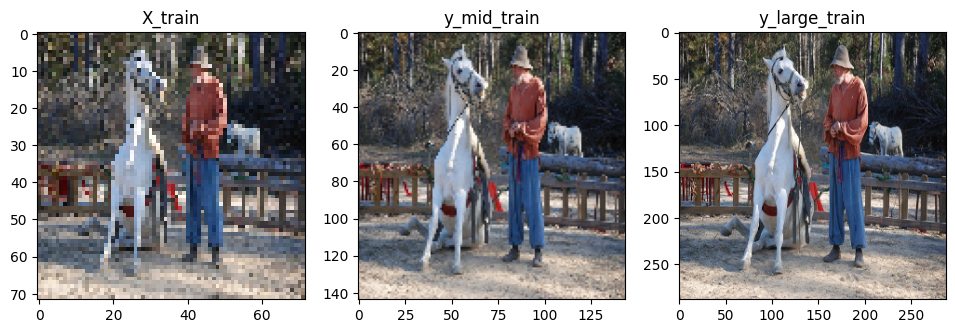

In [12]:
tempDataset = BlurryDataset(X_train[:5], 72, 144, 288)
temp_loader = DataLoader(dataset=tempDataset, batch_size=5, num_workers=0)

# obtain one batch of training images
dataiter = iter(temp_loader)
x, y, z = next(dataiter)
list_imgee = []
for i in [x,y,z]:
    i = i.numpy()
    list_imgee.append(i)

fig = plt.figure(figsize=(20,10))
labels = ["X_train", "y_mid_train", "y_large_train"]
for idx in np.arange(3):
    ax = fig.add_subplot(2, 5, idx+1).set_title(labels[idx])        
    plt.imshow(np.transpose(list_imgee[idx][0], (1, 2, 0)))

In [13]:
df = pd.DataFrame({"Width": [] , "height": []})
for i in list_images:
    im = Image.open(i)
    width, height = im.size
    new_row = pd.DataFrame({'Width': [width], 'height': [height]})
    df = df.append(new_row)
print('Witdh --> Mean:', np.mean(df['Width']),', STD:',np.std(df['Width']))
print('Height --> Mean:', np.mean(df['height']),', STD:',np.std(df['height']))

Witdh --> Mean: 475.60132890365446 , STD: 54.20596133342892
Height --> Mean: 381.7043189368771 , STD: 62.95003250708029


In [ ]:
sns.distplot(df['Width'],hist=True,hist_kws={'edgecolor':'black'})

In [ ]:
sns.distplot(df['height'],hist=True,hist_kws={'edgecolor':'black'})

### Step 2 - Create a Initial model, return y_mid image

In [18]:
class SuperResulutionModel1(nn.Module):
    def __init__(self):
        super(SuperResulutionModel1,self).__init__()
        # convolutional layer 1
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        # convolutional layer 2
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        # up sampling layer
        self.upsamp = nn.Upsample(scale_factor=2, mode='nearest')
        # convolutional layer 3
        self.conv3 = nn.Conv2d(64, 3, 1, padding=0)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.upsamp(x)
        x = self.conv3(x)
        return x

model = SuperResulutionModel1()

In [19]:
def show_sample_from_test(model, data_loader):
    for x, y_mid, y_lar in data_loader:
        x = x.to(device)
        model.to(device)
        pred = model(x)
        m = y_mid
        pred = pred.cpu().detach().numpy()
        m = m.cpu().detach().numpy()
        break

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(2, 5, 1).set_title("Predicted")   
    plt.imshow(np.transpose(pred[0], (1, 2, 0)))
    ax = fig.add_subplot(2, 5, 2).set_title("Target")
    plt.imshow(np.transpose(m[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


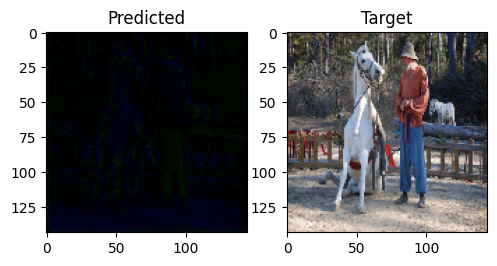

In [25]:
show_sample_from_test(model,temp_loader)

**Fit first model**

In [26]:
def accuracy_metric(y_true, y_pred):
    y_true, y_pred = y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy()
    return PSNR(y_true, y_pred, data_range =1.0)

In [27]:
def train_loop(model, dataLoader, loss_fn, optimizer, device, print_every_n=100):
    model.train()
    train_loss = 0.0
    psnr_loss = 0.0
    size = len(dataLoader.dataset)
    num_batches = len(dataLoader)
    count = 0
    for batch, (x, y_mid, y_large) in enumerate(dataLoader):
        # move tensors to GPU if available
        x, y_mid = x.to(dtype=torch.float) , y_mid.to(dtype=torch.float)
        x, y_mid, y_large = x.to(device), y_mid.to(device), y_large.to(device)
        output = model(x) 
        loss = loss_fn(output, y_mid)
        train_loss += loss
        psnr = accuracy_metric(y_mid, output)
        psnr_loss += psnr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += len(x)
        if batch % print_every_n == 0:
            print(f'train loss = {train_loss:.3f}, after iteration {count}/{size} of samples')
                
    train_loss /= num_batches #total of loss divide by number of batches
    psnr_loss /= size
    return train_loss, psnr_loss

In [28]:
def valid_loop(model, dataLoader, loss_fn, device, print_every_n=100):
    model.eval()
    size=len(dataLoader.dataset)
    num_batches = len(dataLoader)
    val_loss = 0.0
    psnr_loss = 0.0
    with torch.no_grad():
        for x, y_mid, y_large in dataLoader:
            x, y_mid = x.to(dtype=torch.float) , y_mid.to(dtype=torch.float)
            x, y_mid, y_large = x.to(device), y_mid.to(device), y_large.to(device)
            pred = model(x)
            loss = loss_fn(pred,y_mid).item()
            val_loss += loss
            psnr = accuracy_metric(y_mid, pred)
            psnr_loss += psnr

    val_loss /= num_batches
    psnr_loss /= size
    print(f'valid_loss = {val_loss:2f} , psnr = {psnr_loss:.3f}')
    show_sample_from_test(dataLoader)
    return (val_loss, psnr_loss)

In [29]:
def train_eval(loop_for_train, loop_for_valid, params, Step, model, epochs, criterion, optimizer, limit, batch_size, train_loader, val_loader):
    run = neptune.init_run(
    project="zivyo/Assignment-3",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyODExOGY3Ni1iOGRhLTRiYjMtYmJkNC0zYzJjNDA0MjAwMDcifQ==",
    )  # your credentials

    run["Step_Mission"] = Step
    run["parameters"] = params

    early_stop = 0
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(epochs):
        print(f'epoch: {epoch+1} / {epochs}')
        start_time = time.time()
        train_loss, train_psnr = loop_for_train(model, train_loader, criterion, optimizer, device)
        train_time = (time.time() - start_time) / 60 ## Minutes
        print(f'Finish training epoch {epoch+1} with train loss: {train_loss:4f}')
        val_loss, val_psnr = loop_for_valid(model, val_loader, criterion, device)

        run["train/loss"].log(train_loss)
        run["train/psnr"].log(train_psnr)
        run["train/run_time"].log(train_time)
        run["validation/loss"].log(val_loss)
        run["validation/psnr"].log(val_psnr)

                # save model if validation loss has decreased
        if val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss))
            valid_loss_min = val_loss
            early_stop = 0
                
            model_scripted = torch.jit.script(model) # Export to TorchScript
            model_scripted.save('model_scripted.pt') # Save
        else:
            early_stop += 1
        if early_stop == limit:
            break

    print("Finish")            
    run.stop()
    

In [ ]:
learning_rate = 1e-3
epochs = 10
model = SuperResulutionModel1()
model.to(device)
# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
limit = 10 # with Un-improvment
batch_size = 10
train_loader = DataLoader(dataset=BlurryDataset(X_train, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=BlurryDataset(X_val, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)

params = {"criterion": "MSE", 
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "max_epochs": epochs,
        "Lmit": limit}
Step = "Super_Resulution_Model_1"

train_eval(train_loop, valid_loop, params, Step, model, epochs, loss_fn, optimizer, limit, batch_size, train_loader, valid_loader)

### Step 3 - Add another block, return y_mid & y_large image

In [30]:
class SuperResulutionModel2(nn.Module):
    def __init__(self):
        super(SuperResulutionModel2,self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsamp = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(64, 3, 1, padding=0)
        self.conv4 = nn.Conv2d(3, 3, 1, padding=0)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)

        # for mid output
        mid = self.upsamp(x)
        mid = self.conv3(mid)

        # for large ouput
        large = self.upsamp(mid)
        large = self.conv4(large)

        return mid, large

model = SuperResulutionModel2()

In [33]:
def plot_samples(model, dataloader):
    for x, y_mid, y_lar in dataloader:
        x = x.to(device)
        model = model.to(device)
        pred1,pred2 = model(x)
        m = y_mid.to(device)
        l = y_lar.to(device)
        break

    pred1, pred2 = pred1.cpu().detach().numpy(), pred2.cpu().detach().numpy()
    m, l= m.cpu().detach().numpy(), l.cpu().detach().numpy()
    
    temp = random.randint(0,4)
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(2, 5, 1).set_title("Predicted_mid")   
    plt.imshow(np.transpose(pred1[temp], (1, 2, 0)))
    ax = fig.add_subplot(2, 5, 2).set_title("y_mid")
    plt.imshow(np.transpose(m[temp], (1, 2, 0)))
    ax = fig.add_subplot(2, 5, 3).set_title("Predicted_large")   
    plt.imshow(np.transpose(pred2[temp], (1, 2, 0)))
    ax = fig.add_subplot(2, 5, 4).set_title("y_large")
    plt.imshow(np.transpose(l[temp], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


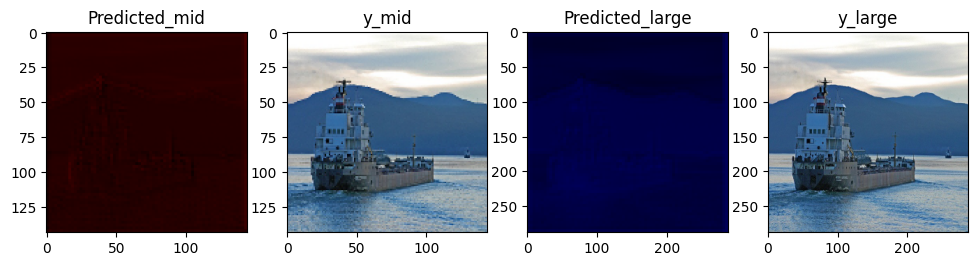

In [34]:
plot_samples(model, temp_loader)

In [35]:
def train_loop2(model, dataLoader, loss_fn, optimizer, device, print_every_n=100):
    model.train()
    train_loss = 0.0
    psnr_loss = 0.0
    size = len(dataLoader.dataset)
    num_batches = len(dataLoader)
    count = 0
    for batch, (x, y_mid, y_large) in enumerate(dataLoader):
        # move tensors to GPU if available
        x, y_mid = x.to(dtype=torch.float) , y_mid.to(dtype=torch.float)
        x, y_mid, y_large = x.to(device), y_mid.to(device), y_large.to(device)
        # 2 outputs
        output_mid, output_large = model(x)
        loss = loss_fn(output_large, y_large)
        loss += loss_fn(output_mid, y_mid)
        train_loss += loss
        psnr = accuracy_metric(y_mid, output_mid)
        psnr += accuracy_metric(y_large, output_large)
        psnr_loss += psnr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += len(x)
        if batch % print_every_n == 0:
            print(f'train loss = {train_loss:.3f}, after iteration {count}/{size} of samples')
                
    train_loss /= num_batches #total of loss divide by number of batches
    psnr_loss /= size
    # print(f'Finish training epoch {i+1} with train loss: {train_loss:4f}')
    return train_loss, psnr_loss

In [36]:
def valid_loop2(model, dataLoader, loss_fn, device, print_every_n=100):
    model.eval()
    size=len(dataLoader.dataset)
    num_batches = len(dataLoader)
    val_loss = 0.0
    psnr_loss = 0.0
    with torch.no_grad():
        for x, y_mid, y_large in dataLoader:
            x, y_mid = x.to(dtype=torch.float) , y_mid.to(dtype=torch.float)
            x, y_mid, y_large = x.to(device), y_mid.to(device), y_large.to(device)
            pred1, pred2 = model(x)
            val_loss += loss_fn(pred1,y_mid).item()
            val_loss += loss_fn(pred2,y_large).item()
            psnr_loss += accuracy_metric(y_mid, pred1)
            psnr_loss += accuracy_metric(y_large, pred2)

    val_loss /= num_batches
    psnr_loss /= size
    print(f'valid_loss = {val_loss:2f} , psnr = {psnr_loss:.3f}')
    plot_samples(model, temp_loader)
    return (val_loss, psnr_loss)

In [ ]:
learning_rate = 1e-3
epochs = 15
model = SuperResulutionModel2()
model.to(device)
# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
limit = 10 # with Un-improvment
batch_size = 10
train_loader = DataLoader(dataset=BlurryDataset(X_train, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=BlurryDataset(X_val, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)

params = {"criterion": "MSE", 
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "max_epochs": epochs,
        "Lmit": limit}
Step = "Super_Resulution_Model_2"

train_eval(train_loop2, valid_loop2, params, Step, model, epochs, loss_fn, optimizer, limit, batch_size, train_loader, valid_loader)

### Step 4 - Residual Block

In [37]:
class SuperResulutionModel3(nn.Module):
    def __init__(self):
        super(SuperResulutionModel3,self).__init__()
        ## Blocks
        # convolutional layer 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # convolutional layer 2
        self.conv2 = nn.Conv2d(32, 3, 3, padding=1)
        # convolutional layer 3
        self.conv3 = nn.Conv2d(3, 32, 3, padding=1)
        # convolutional layer 4
        self.conv4 = nn.Conv2d(32, 3, 3, padding=1)
        # convolutional layer 3
        self.conv5 = nn.Conv2d(3, 32, 1, padding=0)
        # convolutional layer 4
        self.conv6 = nn.Conv2d(32, 3, 1, padding=0)

        # up sampling layer
        self.upsamp = nn.Upsample(scale_factor=2, mode='nearest')
        # convolutional layer 5
        self.conv7 = nn.Conv2d(3, 3, 1, padding=0)
        # convolutional layer 6
        self.conv8 = nn.Conv2d(3, 3, 1, padding=0)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        #block 1
        x_block1 = self.conv1(x)
        x_block1= self.conv2(x_block1)
        x_block1 += x
        x_block1 = self.relu(x_block1)

        #block 2
        x_block2 = self.conv3(x_block1)
        x_block2= self.conv4(x_block2)
        x_block2 += x_block1
        x_block2 = self.relu(x_block2)

        mid1 = self.upsamp(x_block2)

        # for mid output
        mid = self.conv7(mid1)

        # for large ouput
        #block 3
        x_block3 = self.conv5(mid1)
        x_block3= self.conv6(x_block3)
        x_block3 += mid1
        x_block3 = self.relu(x_block3)
        large = self.upsamp(x_block3)
        # print(large.shape)
        large = self.conv8(large)
        # print(large.shape)

        return mid, large

model = SuperResulutionModel3()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


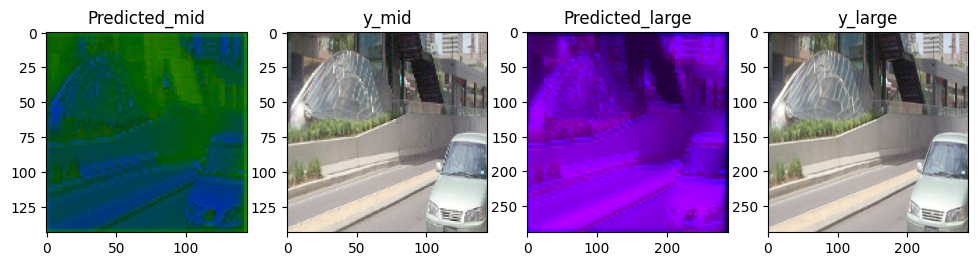

In [38]:
plot_samples(model, temp_loader)

In [ ]:
learning_rate = 2e-3
epochs = 15
model = SuperResulutionModel3()
model.to(device)
# Define the loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate, betas = (0.9, 0.95))
limit = 10 # with Un-improvment
batch_size = 10
train_loader = DataLoader(dataset=BlurryDataset(X_train, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=BlurryDataset(X_val, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)

params = {"criterion": "MAE", 
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "max_epochs": epochs,
        "Lmit": limit}
Step = "Super_Resulution_Model_1"

train_eval(train_loop2, valid_loop2, params, Step, model, epochs, loss_fn, optimizer, limit, batch_size, train_loader, valid_loader)

### Step 5 - (Atrous) convolutional block

In [39]:
class SuperResulutionModel4(nn.Module):
    def __init__(self):
        super(SuperResulutionModel4,self).__init__()
        ## Blocks
        # Atrous 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=4, dilation=4)
        self.conv4 = nn.Conv2d(96, 32, 3, padding=1)
        
        # Atrous 2
        self.conv5 = nn.Conv2d(32, 32, 3, padding=1, dilation=1)
        self.conv6 = nn.Conv2d(32, 32, 3, padding=2, dilation=2)
        self.conv7 = nn.Conv2d(32, 32, 3, padding=4, dilation=4)
        self.conv8 = nn.Conv2d(96, 32, 3, padding=1)

        # Atrous 3
        self.conv9 = nn.Conv2d(32, 32, 3, padding=1, dilation=1)
        self.conv10 = nn.Conv2d(32, 32, 3, padding=2, dilation=2)
        self.conv11 = nn.Conv2d(32, 32, 3, padding=4, dilation=4)
        self.conv12 = nn.Conv2d(96, 32, 3, padding=1)

        self.upsamp = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv13 = nn.Conv2d(32, 3, 1, padding=0)
        self.conv14 = nn.Conv2d(32, 3, 1, padding=0)
        self.leaky_relu = nn.LeakyReLU(0.1)
        
    def forward(self,x):
        #Atrous 1
        x_block1 = self.conv1(x)
        x_block2= self.conv2(x_block1)
        x_block3= self.conv3(x_block2)
        x_block = torch.cat([x_block1, x_block2, x_block3], dim=1)
        x_block = self.leaky_relu(x_block)
        x_block = self.conv4(x_block)

        #Atrous 2
        x_block1 = self.conv5(x_block)
        x_block2= self.conv6(x_block1)
        x_block3= self.conv7(x_block2)
        x_block = torch.cat([x_block1, x_block2, x_block3], dim=1)
        x_block = self.leaky_relu(x_block)
        x_block = self.conv8(x_block)

        mid1 = self.upsamp(x_block)

        # for mid output
        mid = self.conv13(mid1)

        # for large ouput
        #Atrous 2
        x_block1 = self.conv9(mid1)
        x_block2= self.conv10(x_block1)
        x_block3= self.conv11(x_block2)
        x_block = torch.cat([x_block1, x_block2, x_block3], dim=1)
        x_block = self.leaky_relu(x_block)
        x_block = self.conv12(x_block)
        large = self.upsamp(x_block)
        # print(large.shape)
        large = self.conv14(large)
        # print(large.shape)

        return mid, large

model = SuperResulutionModel4()

In [ ]:
plot_samples(model, temp_loader)

In [ ]:
learning_rate = 2e-4
epochs = 20
model = SuperResulutionModel4()
model.to(device)
# Define the loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
limit = 10 # with Un-improvment
batch_size = 10
train_loader = DataLoader(dataset=BlurryDataset(X_train, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=BlurryDataset(X_val, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)

params = {"criterion": "MAE", 
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "max_epochs": epochs,
        "Lmit": limit}
Step = "Super_Resulution_Model_4"

train_eval(train_loop2, valid_loop2, params, Step, model, epochs, loss_fn, optimizer, limit, batch_size, train_loader, valid_loader)

#### **Trying different between ReLU and Leaky ReLU**

In [41]:
class SuperResulutionModel4(nn.Module):
    def __init__(self):
        super(SuperResulutionModel4,self).__init__()
        ## Blocks
        # Atrous 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=4, dilation=4)
        self.conv4 = nn.Conv2d(96, 32, 3, padding=1)
        
        # Atrous 2
        self.conv5 = nn.Conv2d(32, 32, 3, padding=1, dilation=1)
        self.conv6 = nn.Conv2d(32, 32, 3, padding=2, dilation=2)
        self.conv7 = nn.Conv2d(32, 32, 3, padding=4, dilation=4)
        self.conv8 = nn.Conv2d(96, 32, 3, padding=1)

        # Atrous 3
        self.conv9 = nn.Conv2d(32, 32, 3, padding=1, dilation=1)
        self.conv10 = nn.Conv2d(32, 32, 3, padding=2, dilation=2)
        self.conv11 = nn.Conv2d(32, 32, 3, padding=4, dilation=4)
        self.conv12 = nn.Conv2d(96, 32, 3, padding=1)

        # up sampling layer
        self.upsamp = nn.Upsample(scale_factor=2, mode='nearest')
        # convolutional layer 5
        self.conv13 = nn.Conv2d(32, 3, 1, padding=0)
        # convolutional layer 6
        self.conv14 = nn.Conv2d(32, 3, 1, padding=0)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        #Atrous 1
        x_block1 = self.conv1(x)
        x_block2= self.conv2(x_block1)
        x_block3= self.conv3(x_block2)
        x_block = torch.cat([x_block1, x_block2, x_block3], dim=1)
        x_block = self.relu(x_block)
        x_block = self.conv4(x_block)

        #Atrous 2
        x_block1 = self.conv5(x_block)
        x_block2= self.conv6(x_block1)
        x_block3= self.conv7(x_block2)
        x_block = torch.cat([x_block1, x_block2, x_block3], dim=1)
        x_block = self.relu(x_block)
        x_block = self.conv8(x_block)

        mid1 = self.upsamp(x_block)

        # for mid output
        mid = self.conv13(mid1)

        # for large ouput
        #Atrous 2
        x_block1 = self.conv9(mid1)
        x_block2= self.conv10(x_block1)
        x_block3= self.conv11(x_block2)
        x_block = torch.cat([x_block1, x_block2, x_block3], dim=1)
        x_block = self.relu(x_block)
        x_block = self.conv12(x_block)
        large = self.upsamp(x_block)
        # print(large.shape)
        large = self.conv14(large)
        # print(large.shape)

        return mid, large

model = SuperResulutionModel4()

In [ ]:
learning_rate = 2e-4
epochs = 20
model = SuperResulutionModel4()
model.to(device)
# Define the loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
limit = 10 # with Un-improvment
batch_size = 10
train_loader = DataLoader(dataset=BlurryDataset(X_train, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=BlurryDataset(X_val, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)

params = {"criterion": "MAE", 
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "max_epochs": epochs,
        "Lmit": limit}
Step = "Super_Resulution_Model_4_relu"

train_eval(train_loop2, valid_loop2, params, Step, model, epochs, loss_fn, optimizer, limit, batch_size, train_loader, valid_loader)

### Step 6 - Add pretrained network feature extractor

In [42]:
class SuperResulutionModel5(nn.Module):
    def __init__(self):
        super(SuperResulutionModel5,self).__init__()
        self.feature_layer = ["features.2"] 
        self.pre_train_net = create_feature_extractor(models.vgg16(pretrained = True), return_nodes = self.feature_layer)
        self.transform = transforms.Resize((72,72))

        # up sampling layer
        self.upsamp = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 3, 1, padding=0)
        self.conv4 = nn.Conv2d(128, 3, 1, padding=0)
#         self.leaky_relu = nn.LeakyReLU(0.1)
        
    def forward(self,x):
        #first 2 conv layers
        x_conv = self.conv1(x)
        x_conv = self.conv2(x_conv)
        #feature extraction
        with torch.no_grad():
            x = self.pre_train_net(x)
        x_conv = self.transform(x_conv)
        #concatenate
        x = torch.cat([x_conv, x['features.2']], dim=1)
#         x = self.leaky_relu(x)

        mid1 = self.upsamp(x)

        # for mid output
        mid = self.conv3(mid1)

        # for large ouput
        large = self.upsamp(mid1)
        large = self.conv4(large)

        return mid, large

model = SuperResulutionModel5()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


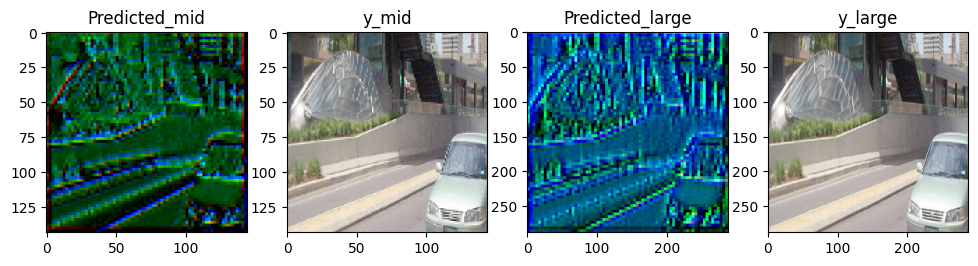

In [43]:
plot_samples(model, temp_loader)

In [ ]:
learning_rate = 2e-4
epochs = 15
model = SuperResulutionModel5()
model.to(device)
# Define the loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
limit = 10 # with Un-improvment
batch_size = 10
train_loader = DataLoader(dataset=BlurryDataset(X_train, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=BlurryDataset(X_val, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)

params = {"criterion": "MAE", 
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "max_epochs": epochs,
        "Lmit": limit}
Step = "Super_Resulution_Model_5"

train_eval(train_loop2, valid_loop2, params, Step, model, epochs, loss_fn, optimizer, limit, batch_size, train_loader, valid_loader)

### Step 7 - Use Pixel shuffle

In [ ]:
class SuperResulutionModel6(nn.Module):
    def __init__(self):
        super(SuperResulutionModel6,self).__init__()
        self.feature_layer = ["features.2"] 
        self.pre_train_net = create_feature_extractor(models.vgg16(pretrained = True), return_nodes = self.feature_layer)
        self.transform = transforms.Resize((72,72))

        # up sampling layer
        self.upsamp = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 1, padding=0)
        self.conv4 = nn.Conv2d(8, 3, 1, padding=0)
        
    def forward(self,x):
        #first 2 conv layers
        x_conv = self.conv1(x)
        x_conv = self.conv2(x_conv)
        #feature extraction
        with torch.no_grad():
            x = self.pre_train_net(x)
        x_conv = self.transform(x_conv)
        #concatenate
        x = torch.cat([x_conv, x['features.2']], dim=1)
        # for mid output
        x = pixel_shuffle(x, 2)
        mid = self.conv3(x)
        # for large ouput
        large = pixel_shuffle(x, 2)
        large = self.conv4(large)

        return mid, large

model = SuperResulutionModel6()

In [ ]:
learning_rate = 5e-4
epochs = 15
model = SuperResulutionModel6()
model.to(device)
# Define the loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
limit = 10 # with Un-improvment
batch_size = 10
train_loader = DataLoader(dataset=BlurryDataset(X_train, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=BlurryDataset(X_val, 72, 144, 288), batch_size=batch_size,shuffle=True, num_workers=0)

params = {"criterion": "MAE", 
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "max_epochs": epochs,
        "Lmit": limit}
Step = "Super_Resulution_Model_6"

train_eval(train_loop2, valid_loop2, params, Step, model, epochs, loss_fn, optimizer, limit, batch_size, train_loader, valid_loader)

### Step 8 - Create a gif

In [ ]:
def plot_samples2(model, dataloader):
    for x, y_mid, y_lar in dataloader:
        x = x.to(device)
        model = model.to(device)
        pred1,pred2 = model(x)
        m = y_mid.to(device)
        l = y_lar.to(device)
        break

    pred1, pred2 = pred1.cpu().detach().numpy(), pred2.cpu().detach().numpy()
    m, l= m.cpu().detach().numpy(), l.cpu().detach().numpy()
    
    fig = plt.figure(figsize=(40,30))
    ax = fig.add_subplot(2, 5, 1).set_title("Predicted_mid")   
    plt.imshow(np.transpose(pred1[0], (1, 2, 0)))
    ax = fig.add_subplot(2, 5, 3).set_title("Predicted_large")   
    plt.imshow(np.transpose(pred2[0], (1, 2, 0)))

In [ ]:
import imageio
images = []
new_dir = data_dir + "/gif"
gif_images = glob.glob(new_dir + "/*")
for filename in gif_images:
    images.append(imageio.imread(filename))
imageio.mimsave('/path/to/movie.gif', images)